#### Imports

In [2]:
import pandas as pd
import os
import cProfile
import re
import sys
from pathlib import Path
from datetime import datetime
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

notebook_dir = Path().resolve()
pyres_dir = str(notebook_dir.parent) + "/PyRes"
sys.path.append(pyres_dir)
import pyres_fof

os.environ["TPTP"] = str(notebook_dir) + "/TPTP-v9.0.0"

### Create Run-scripts

In [ ]:
import math
if False:
    from tqdm import trange
    abstract_runscript_content = """#!/bin/tcsh
#
# This is a StarExec runscript for PyRes. See https://www.starexec.org.
#
# To use this, build a StarExec package with "make starexec" and
# upload it to a StarExec cluster - then follow local instructions
# ;-).
#

ml python
echo -n "% Problem    : " ; head -2 $1 | tail -1 | sed -e "s/.*  : //"
set ProblemSPC=`grep " SPC " $1 | sed -e "s/.* : //"`
set default_flags="-tifbsVp -nlargest -HPickGiven5"
set rel_flags="-r [rel_distance]"
set final=" "$1
set ecmd="python3 ./pyres_fof.py $default_flags $rel_flags $final"
python3 --version
if ( `expr "$ProblemSPC" : "FOF.*"` || `expr "$ProblemSPC" : "CNF.*"` ) then
    echo "% Command    : " $ecmd
    /home/starexec/bin/GetComputerInfo -p THIS Model CPUModel RAMPerCPU OS | \
        sed -e "s/Computer     /% Computer   /" \
            -e "s/Model        /% Model      /" \
            -e "s/CPUModel     /% CPU        /" \
            -e "s/RAMPerCPU    /% Memory     /" \
            -e "s/OS           /% OS         /"
    echo -n "% CPULimit   : " ; echo "$STAREXEC_CPU_LIMIT"
    echo -n "% DateTime   : " ; date
    echo "% CPUTime    : "
    $ecmd
else
    echo "% SZS status Inappropriate"
endif

    """

    abstract_file_name = "run_scripts/starexec_run_PyRes_rd_[rel_distance]"

    for f in os.listdir("run_scripts/"):
        os.remove(os.path.join("run_scripts/", f))

    X = np.arange(0, 10)
    def get_rel_distances(X, end_of_linear):
        a = 10
        steepness_expo = 1.5
        additive = -(end_of_linear/a)+steepness_expo
        return np.real(np.where(
            X<=(end_of_linear/a),
            a*X,
            a*(np.emath.logn(steepness_expo, X+additive)*(X+additive)-additive)
        )).astype(int).tolist()

    rel_distances = get_rel_distances(X, 50)
    rel_distances = [2, 3, 5, 8, 13, 21, 33, 54]
    print(rel_distances)

    for x in tqdm(rel_distances):
        def substitute(text): return text.replace("[rel_distance]", f"{x:03d}")

        file_name = substitute(abstract_file_name)
        file_content = substitute(abstract_runscript_content)
        with open(file_name, "w") as file:
            file.write(file_content)


[2, 3, 5, 8, 13, 21, 33, 54]


100%|██████████| 8/8 [00:00<00:00, 6656.30it/s]


## Data sources

### Data source 1: Previous PyRes run on TPTP

In [2]:
df_tptp_pyres = pd.read_csv(
    "../notes/meeting/protocol_default.csv",
    comment="#",
    sep='\\s+')
df_tptp_pyres["Usertime"] = df_tptp_pyres["Usertime"].round(decimals=0)
df_tptp_pyres = df_tptp_pyres.sort_values("Usertime", ascending=False)

df_tptp_pyres

,Problem,Status,Usertime,Failure,Version,Preprocessingtime,Backward_subsumed,Factors_computed,Forward_subsumed,Initial_clauses,Processed_clauses,Resolvents_computed,Systemtime,Tautologies_deleted,Totaltime
13131,SWV194+1.p,T,99.852,success,1.2,-,4,1,1960,357,2166,98975,0.371,2,100.223
5358,LAT261-1.p,T,99.759,success,1.2,-,12,5,5673,3038,3687,61459,0.138,72,99.897
11919,SWB011+1.p,T,99.539,success,1.2,-,25,198,4675,1281,3675,43267,0.120,58,99.659
5094,LAT005-2.p,T,98.176,success,1.2,-,55,0,4391,31,3966,9397,0.032,339,98.208
2021,FLD021-3.p,T,97.506,success,1.2,-,6,8,96,30,1970,277716,0.371,10,97.877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,LAT362+3.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5723,LAT362+4.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5724,LAT363+1.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-
5725,LAT363+2.p,F,-,unknown,1.2,-,-,-,-,-,-,-,-,-,-


### Data source 2: TPTP problem files

#### Step 1: Gather data

In [37]:
load_from_file = True
store = False
if load_from_file:
    df_tptp = pd.read_csv("../src/df_tptp.csv", index_col=0)
else:
    parameters = {
        "spc":          r"(?<=% SPC      :)(\s+\w+)",
        "n_formulae":   r"(?<=formulae    :)(\s+\d+)",
        "n_atoms":      r"(?<=atoms       :)(\s+\d+)",
        "n_clauses":    r"(?<=clauses     :)(\s+\d+)",
        "n_literals":   r"(?<=literals    :)(\s+\d+)",
        "n_variables":  r"(?<=variables   :)(\s+\d+)",
    }
    problem_configs = []

    problems_dir = "TPTP-v9.0.0/Problems/"
    dir_list = os.listdir(problems_dir)
    for dir_name in tqdm(dir_list, total=len(dir_list)):
        full_dir_name = os.path.join(problems_dir, dir_name)
        downloads_list = os.listdir(full_dir_name)
        for dir_name in downloads_list:
            full_file_name = os.path.join(full_dir_name, dir_name)
            if not os.path.isfile(full_file_name):
                continue
            with open(full_file_name) as full_file_name:
                s_mp_runs = full_file_name.read()
                problem_results: dict = {
                    "Problem": dir_name,
                }
                for identifier, pattern in parameters.items():
                    re_match = re.search(pattern, s_mp_runs)
                    problem_results[identifier] = re_match.group(0) if re_match is not None else None
                problem_results["full_file_name"] = full_file_name.name
                problem_configs.append(problem_results)

    df_tptp = pd.DataFrame.from_records(problem_configs)
df_tptp = df_tptp.fillna(value=np.nan)
if store:
    df_tptp.to_csv("../src/df_tptp.csv")


df_tptp

,Problem,spc,n_formulae,n_atoms,n_clauses,n_literals,n_variables,full_file_name
0,TOP036+4.p,FOF_THM_RFO_SEQ,34431.0,241872.0,NaN,NaN,94759.0,TPTP-v9.0.0/Problems/TOP/TOP036+4.p
1,TOP029+1.p,FOF_THM_RFO_SEQ,109.0,569.0,NaN,NaN,184.0,TPTP-v9.0.0/Problems/TOP/TOP029+1.p
2,TOP042+3.p,FOF_THM_RFO_SEQ,13534.0,83921.0,NaN,NaN,33628.0,TPTP-v9.0.0/Problems/TOP/TOP042+3.p
3,TOP008-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP008-1.p
4,TOP009-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP009-1.p
...,...,...,...,...,...,...,...,...
26272,MED007+1.p,FOF_THM_RFO_NEQ,41.0,201.0,NaN,NaN,96.0,TPTP-v9.0.0/Problems/MED/MED007+1.p
26273,MED006+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED006+1.p
26274,MED012+1.p,FOF_SAT_RFO_NEQ,40.0,190.0,NaN,NaN,93.0,TPTP-v9.0.0/Problems/MED/MED012+1.p
26275,MED008+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED008+1.p


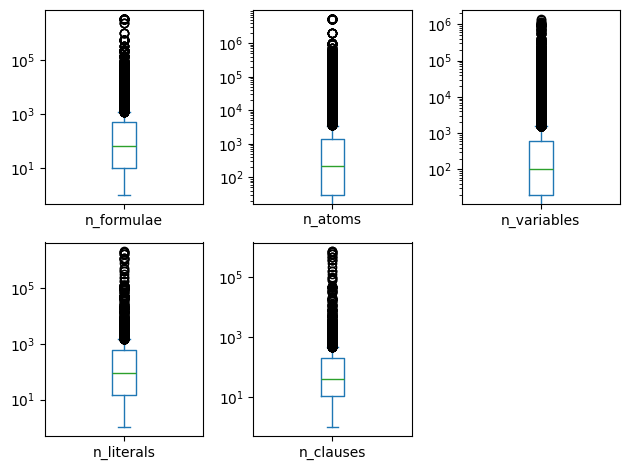

In [26]:
import matplotlib.pyplot as plt
(
    df_tptp
    [["n_formulae", "n_atoms", "n_variables", "n_literals", "n_clauses"]]
    .apply(lambda x: x[x.notnull() & x.notna()])
    .astype(float)
    .plot(kind="box", subplots=True, layout=(2,3), logy=True)
)
plt.tight_layout()


### General Starexec output stuff

In [3]:
starexec_outputs = os.path.join(notebook_dir, "starexec_outputs")
job_index = 5054
problem_folder = os.path.join(starexec_outputs, f"Job{str(job_index)}_output/")

#### Move problem outputs from Downloads to project

In [11]:
# todo: make this safer...

import shutil


downloads_dir = str(notebook_dir.parents[2]) + "/Downloads/"
individual_dir = downloads_dir + f"Job{job_index}_output"
csv_info = downloads_dir + f"Job{job_index}/Job{job_index}_info.csv"

if not Path.exists(Path(problem_folder)):
    os.mkdir(problem_folder)
try:
    shutil.copytree(individual_dir, problem_folder, dirs_exist_ok=True)
    print("Moved folder with individual problem outputs.")
except:
    print("Failed to move individual problem outputs.")
try:
    shutil.move(csv_info, problem_folder)
    print("Moved job csv info.")
except:
    print("Failed to move job csv info.")



Moved folder with individual problem outputs.
Failed to move job csv info.


### Data source 3: StarExec csv output

In [4]:
df_se_csv = pd.read_csv(problem_folder + f"Job{str(job_index)}_info.csv")
df_se_csv

,pair id,benchmark,benchmark id,solver,solver id,configuration,configuration id,status,cpu time,wallclock time,memory usage,result,expected,SZSResult,SZSOutput,SZSStatus
0,127930639,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_rel_rs_1.3_python313,3695,PyRes_rd_002,400487,complete,0.809385,0.946109,119284.0,GaveUp,Unsatisfiable,GUP-Sat,Sat,GUP
1,127930640,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_rel_rs_1.3_python313,3695,PyRes_rd_003,400490,complete,0.868780,1.012920,366588.0,Unsatisfiable,Unsatisfiable,UNS-CRf,CRf,UNS
2,127930641,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_rel_rs_1.3_python313,3695,PyRes_rd_005,400488,complete,0.874784,1.011520,366588.0,Unsatisfiable,Unsatisfiable,UNS-CRf,CRf,UNS
3,127930642,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_rel_rs_1.3_python313,3695,PyRes_rd_008,400484,complete,0.850565,0.994106,119284.0,Unsatisfiable,Unsatisfiable,UNS-CRf,CRf,UNS
4,127930643,jannis_gehring/TPTP v9.0.0/Problems/KRS/KRS001...,4176249,pyres_rel_rs_1.3_python313,3695,PyRes_rd_013,400486,complete,0.860964,0.997113,366588.0,Unsatisfiable,Unsatisfiable,UNS-CRf,CRf,UNS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225587,128156226,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE182...,4176248,pyres_rel_rs_1.3_python313,3695,PyRes_rd_008,400484,pending submission,0.000000,0.000000,0.0,--,Satisfiable,-,-,-
225588,128156227,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE182...,4176248,pyres_rel_rs_1.3_python313,3695,PyRes_rd_013,400486,pending submission,0.000000,0.000000,0.0,--,Satisfiable,-,-,-
225589,128156228,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE182...,4176248,pyres_rel_rs_1.3_python313,3695,PyRes_rd_021,400491,pending submission,0.000000,0.000000,0.0,--,Satisfiable,-,-,-
225590,128156229,jannis_gehring/TPTP v9.0.0/Problems/KLE/KLE182...,4176248,pyres_rel_rs_1.3_python313,3695,PyRes_rd_033,400489,pending submission,0.000000,0.000000,0.0,--,Satisfiable,-,-,-


### Data source 4: StarExec individual job files

#### Step 1: Gather data (.csv) and preprocess (regex)

In [5]:
load_from_file = True
store = False
if load_from_file:
    df_se_indi = pd.read_csv(problem_folder + f"df_se_indi_{str(job_index)}.csv", index_col=0)
else:
    print(f"Searching in {problem_folder}")

    # Get file texts
    file_dir_names = [
        subdir+"/"+files[0]
        for (subdir, dirs, files) in os.walk(problem_folder + "jannis_gehring")
        if len(dirs)==0
    ]
    texts = []
    for full_file_name in tqdm(file_dir_names):
        if not os.path.isfile(full_file_name):
            texts.append(None)
            continue
        with open(full_file_name) as full_file_name:
            s_mp_runs = full_file_name.read()
            texts.append(s_mp_runs)
    df_se_indi = pd.DataFrame({
        "file_dir_name": file_dir_names,
        "text": texts,
    })

    # Search through problems with regex
    # todo: fix: this regex patterns doesnt allow for lines starting with 79.84/10.64
    new_column_specs = [
        ("problem",                         r"(?<=Problem    : )(\S+)(?= : )",               str),
        ("python_version",                  r"(?<=Python )(\S+)",                            str),
        ("cpu_limit",                       r"(?<=% CPULimit   : )\S+",                      int),
        ("pyres_version",                   r"(?<=% Version:  )(\S+)",                       str),
        ("rel_distance",                    r"(?<=# rel_distance: )\S+",                     int),
        ("graph_construction_time",         r"(?<=# graph_construction_time: )(\S+)",        float),
        ("neighbourhood_computation_time",  r"(?<=# neighbourhood_computation_time: )(\S+)", float),
        ("szs_status",                      r"(?<=% SZS status )(\S+)",                      str),
        ("initial_clauses",                 r"(?<=% Initial clauses    : )(\S+)",            int),
        ("processed_clauses",               r"(?<=% Processed clauses  : )(\S+)", 			 int),
        ("factors_computed",                r"(?<=% Factors computed   : )(\S+)", 			 int),
        ("resolvents_computed",             r"(?<=% Resolvents computed: )(\S+)", 			 int),
        ("tautologies_deleted",             r"(?<=% Tautologies deleted: )(\S+)", 			 int),
        ("forward_subsumed",                r"(?<=% Forward subsumed   : )(\S+)", 			 int),
        ("backward_subsumed",               r"(?<=% Backward subsumed  : )(\S+)", 			 int),
        ("user_time",                       r"(?<=% User time          : )(\S+)", 			 float),
        ("system_time",                     r"(?<=% System time        : )(\S+)", 			 float),
        ("total_time",                      r"(?<=% Total time         : )(\S+)", 			 float),
    ]

    for new_column_name, pattern, col_type in tqdm(new_column_specs, desc="Searching for regex patterns"):
        df_se_indi[new_column_name] = (
            df_se_indi["text"]
            .apply(lambda text: re.search(pattern + r"|$", text)[0])
            .apply(lambda text: col_type(text) if text !="" else None)
        )

if store:
    df_se_indi.to_csv(problem_folder + f"df_se_indi_{str(job_index)}.csv")

df_se_indi

,file_dir_name,text,problem,python_version,cpu_limit,pyres_version,rel_distance,graph_construction_time,neighbourhood_computation_time,szs_status,initial_clauses,processed_clauses,factors_computed,resolvents_computed,tautologies_deleted,forward_subsumed,backward_subsumed,user_time,system_time,total_time
0,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.27\tLmod Warning: MODULEPATH is undefin...,PRO032_1,3.6.8,NaN,NaN,NaN,NaN,NaN,Inappropriate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.28\tLmod Warning: MODULEPATH is undefin...,PRO023^1,3.6.8,NaN,NaN,NaN,NaN,NaN,Inappropriate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.28\tLmod Warning: MODULEPATH is undefin...,PRO011+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.28\tLmod Warning: MODULEPATH is undefin...,PRO005+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.28\tLmod Warning: MODULEPATH is undefin...,PRO004+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45102,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.16/0.27\tLmod Warning: MODULEPATH is undefin...,MED007+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45103,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.29\tLmod Warning: MODULEPATH is undefin...,MED006+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45104,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.17/0.28\tLmod Warning: MODULEPATH is undefin...,MED012+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45105,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.16/0.28\tLmod Warning: MODULEPATH is undefin...,MED008+1,3.6.8,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step 2: Create job summary


In [6]:
# df_jobs = pd.read_csv(starexec_outputs + "/df_jobs.csv")
# required column types: Python version, Pyres version, ap_version, Job index, Number of problems, initial_clauses_mean, initial_clauses_std, rel_distance_values
def get_value(series: pd.Series):
    return (
       str(series[ series.notnull() & series.notna() ].unique()[0])
    )

def create_ctrs(szs_stati: list[str]):
   return {
      ("ctr_" + status): len(df_se_indi[df_se_indi["szs_status"]==status])
      for status in szs_stati
   }

def create_float_metric_stats(df, column_name):
   stats_dict = (
      df[df["szs_status"]=="Unsatisfiable"]
      [column_name]
      .describe()
      .to_dict()
   )
   return {
      (column_name + "_" + stat): value
      for stat, value in stats_dict.items()
      if stat != "count"
   }

job_summary = {
    "job_index": job_index,
    "python_version": get_value(df_se_indi["python_version"]),
    "pyres_version": get_value(df_se_indi["pyres_version"]),
    "atp_version": "1.0.0",
    **create_ctrs(["Unsatisfiable", "GaveUp", "Inappropriate",
                     "Satisfiable", "Theorem", "ResourceOut"]),
    **create_float_metric_stats(df_se_indi, "initial_clauses"),
    **create_float_metric_stats(df_se_indi, "graph_construction_time"),
    **create_float_metric_stats(df_se_indi, "neighbourhood_computation_time"),
    **create_float_metric_stats(df_se_indi, "neighbourhood_computation_time"),
    "rel_distance_values": [float(x) for x in df_se_indi["rel_distance"].sort_values().unique()],
}

job_summary

{'job_index': 5054,
 'python_version': '3.6.8',
 'pyres_version': '1.5',
 'atp_version': '1.0.0',
 'ctr_Unsatisfiable': 1216,
 'ctr_GaveUp': 3642,
 'ctr_Inappropriate': 8891,
 'ctr_Satisfiable': 427,
 'ctr_Theorem': 1173,
 'ctr_ResourceOut': 17,
 'initial_clauses_mean': 17.26480263157895,
 'initial_clauses_std': 20.123256687576692,
 'initial_clauses_min': 2.0,
 'initial_clauses_25%': 9.0,
 'initial_clauses_50%': 13.0,
 'initial_clauses_75%': 18.0,
 'initial_clauses_max': 206.0,
 'graph_construction_time_mean': 0.04814791230509865,
 'graph_construction_time_std': 0.1771363535711527,
 'graph_construction_time_min': 0.0001361209999999,
 'graph_construction_time_25%': 0.004080659749999925,
 'graph_construction_time_50%': 0.01157388599999995,
 'graph_construction_time_75%': 0.029797651,
 'graph_construction_time_max': 2.119227132,
 'neighbourhood_computation_time_mean': 0.1285188561891447,
 'neighbourhood_computation_time_std': 0.325162953583206,
 'neighbourhood_computation_time_min': 2.571

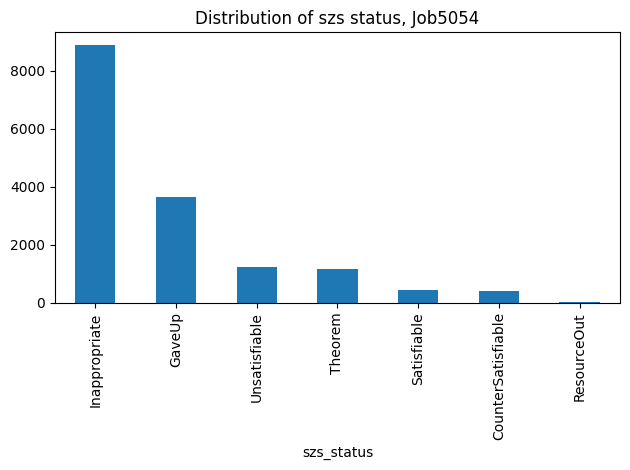

In [7]:
(
    df_se_indi["szs_status"]
    .value_counts()
    .plot(kind="bar", title=f"Distribution of szs status, Job{job_index}")
)
plt.tight_layout()

In [111]:
df_se_indi[df_se_indi["szs_status"]=="Satisfiable"]["file_dir_name"].reset_index(drop=True)[0]

'/Users/jannisgehring/VSCode/coursework-pyres/src/starexec_outputs/Job5054_output/jannis_gehring/TPTP v9.0.0/Problems/KRS/pyres_rel_rs_1.3_python313___PyRes_rd_013/KRS005-1.p/127930691.txt'

0.8820019782416023

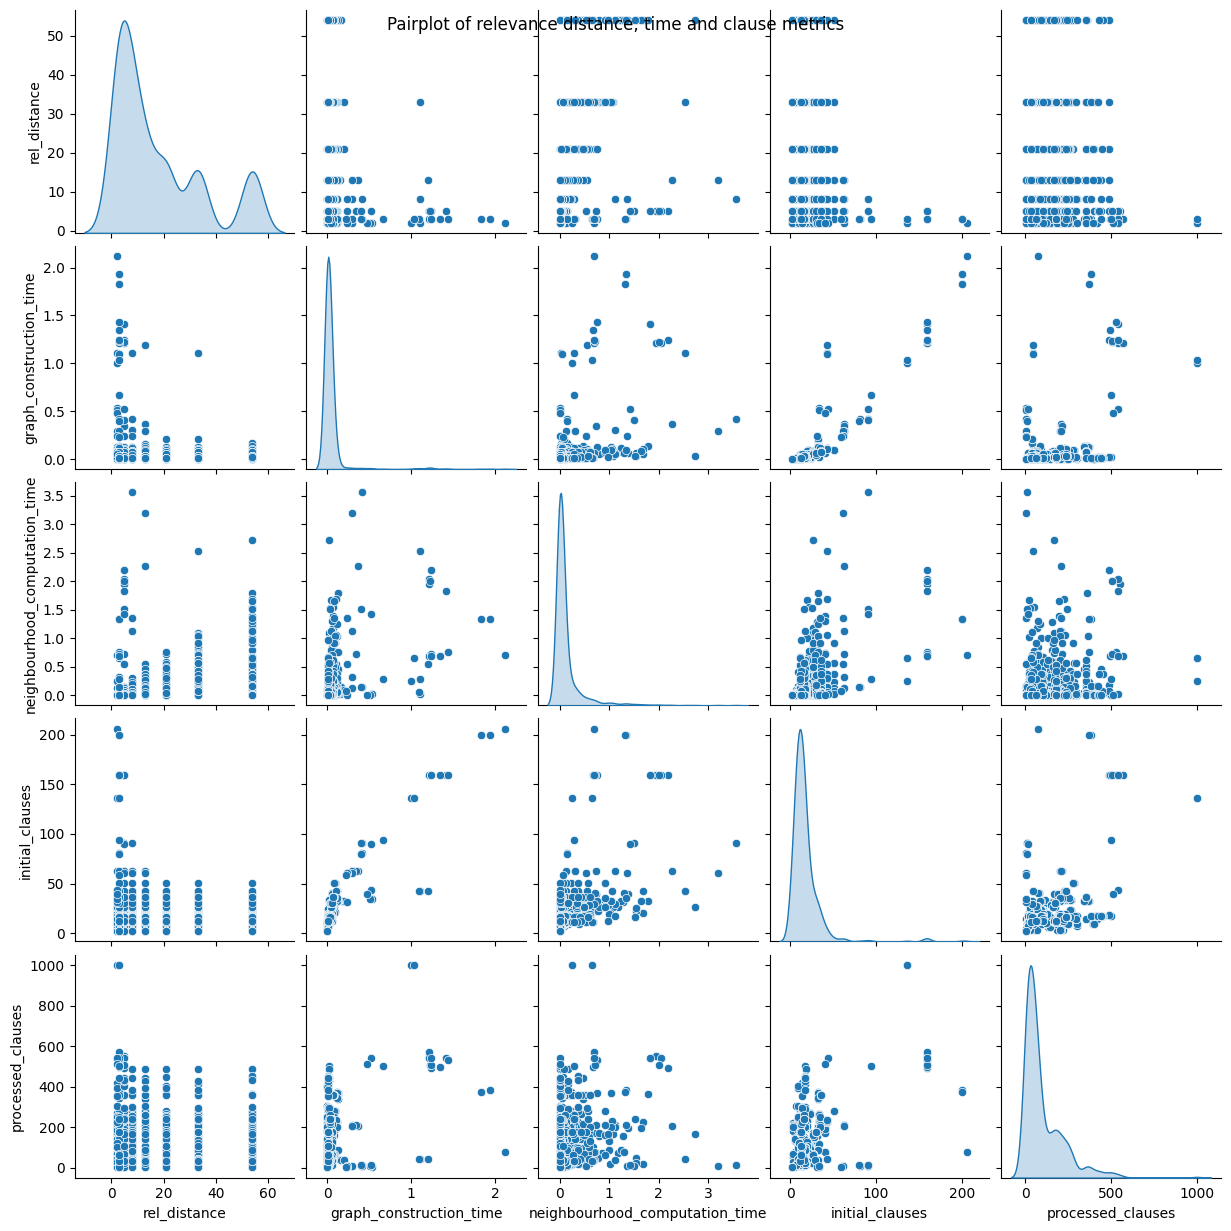

In [74]:
df_filtered = (
    df_se_indi
    [
        # df_se_indi["rel_distance"].notnull()
         (df_se_indi["szs_status"]=="Unsatisfiable")
        # & (df_se_indi["graph_construction_time"]<1)
    ]
    .reset_index(drop=True)
)

# df_filtered["summed_time"] = df_filtered["graph_construction_time"] + df_filtered["neighbourhood_computation_time"]
# df_filtered.plot.scatter(x="rel_distance", y="graph_construction_time")
# df_filtered.plot.scatter(x="rel_distance", y="neighbourhood_computation_time")
# df_filtered.plot.scatter(x="rel_distance", y="summed_time")
plot = sns.pairplot(
    df_filtered[
        ["rel_distance", "graph_construction_time", "neighbourhood_computation_time",
         "initial_clauses", "processed_clauses"]
        ],
    diag_kind="kde",
)
plot.fig.suptitle("Pairplot of relevance distance, time and clause metrics")
float(df_filtered["initial_clauses"].corr(df_filtered["graph_construction_time"]))

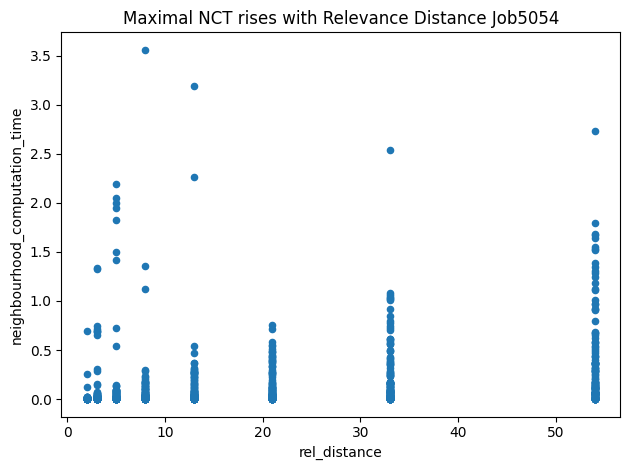

Linear Regression for initial_clauses and graph_construction_time
Intercept: -0.08589399857643551
Coefficient: 0.0077638831871937476
Linear Regression for rel_distance and neighbourhood_computation_time
Intercept: 0.03202102792609143
Coefficient: 0.00545190536485958


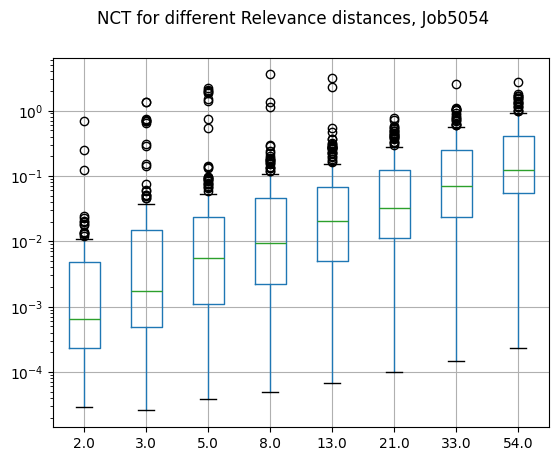

In [107]:
from sklearn.linear_model import LinearRegression

df_filtered = (
    df_se_indi
    [
         (df_se_indi["szs_status"]=="Unsatisfiable")
    ]
    .reset_index(drop=True)
)

(
    df_filtered
    .plot
    .scatter(
        x="rel_distance",
        y="neighbourhood_computation_time",
        title=f"Maximal NCT rises with Relevance Distance Job{job_index}",
    )
)
plt.tight_layout()
plt.show()
def compute_linear_regression(x_name, y_name):
    lr = LinearRegression()
    length = len(df_filtered)
    x = df_filtered[x_name].to_numpy()
    y = df_filtered[y_name].to_numpy()
    x = x.reshape(length, 1)
    y = y.reshape(length, 1)
    lr.fit(X=x, y=y)
    print(f"Linear Regression for {x_name} and {y_name}")
    print("Intercept: "+ str(lr.intercept_[0]))
    print("Coefficient: "+ str(lr.coef_[0][0]))

compute_linear_regression("initial_clauses", "graph_construction_time")
compute_linear_regression("rel_distance", "neighbourhood_computation_time")


df_filtered = df_filtered[["rel_distance", "neighbourhood_computation_time"]].pivot(columns="rel_distance")
df_filtered.columns = df_filtered.columns.droplevel()
df_filtered.boxplot().set_yscale("log")
plt.suptitle(f"NCT for different Relevance distances, Job{job_index}")
plt.show()

179

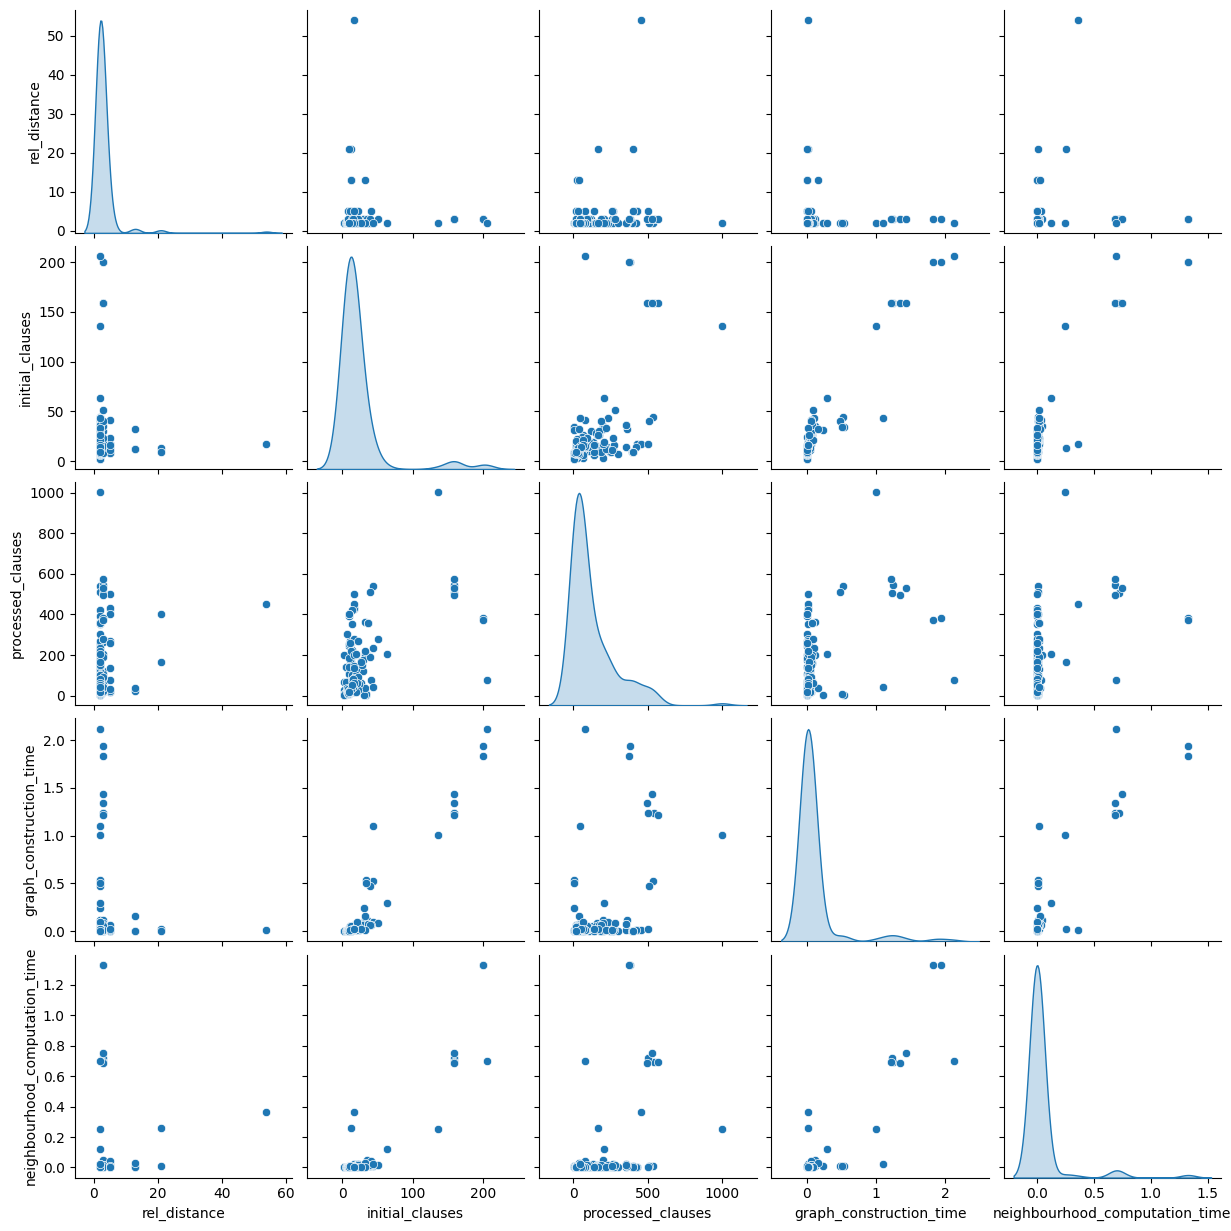

In [17]:

# filter for those runs that solved a problem with the minimal relevance distance
df_filtered = df_filtered.loc[df_filtered.groupby("problem")["rel_distance"].idxmin()]
sns.pairplot(
    df_filtered
    # [
    #     (df_filtered["initial_clauses"]<100)
    #     & (df_filtered["rel_distance"]<18)
    # ]
    [["rel_distance", "initial_clauses", "processed_clauses", "graph_construction_time", "neighbourhood_computation_time"]],
    diag_kind="kde",


)
df_filtered.shape[0]
# (
#     df_filtered
#     [
#         (df_filtered["initial_clauses"]>100)
#         & (df_filtered["rel_distance"]<18)
#     ]
#     ["file_dir_name"]
#     .reset_index(drop=True)
#     [0]
# )

In [43]:
import plotly.express as px
# sns.heatmap(df_se_indi[["rel_distance", "problem", "szs_status"]])#, index="rel_distance", columns="problem", values="szs_status")
df_se_indi["szs_status"].value_counts()
status_to_int = {szs_status: index for index, szs_status in enumerate(df_se_indi["szs_status"].value_counts().index.to_list())}
df_heatmap = df_se_indi[["rel_distance", "problem", "szs_status"]]#.value_counts().unstack()#.pivot(index="problem", columns="rel_distance", values="szs_status")
# sns.heatmap(df_heatmap.replace(status_to_int))
df_heatmap[df_heatmap["rel_distance"] == 5.0]

,rel_distance,problem,szs_status
440,5.0,PRO010+1,Theorem
466,5.0,PRO010+2,Theorem
470,5.0,PRO011+2,Theorem
508,5.0,PRO010+4,Theorem
509,5.0,PRO011+4,Theorem
...,...,...,...
44881,5.0,PHI039+1,CounterSatisfiable
44882,5.0,PHI038+1,CounterSatisfiable
44883,5.0,PHI010+1,Theorem
44884,5.0,PHI012+1,Theorem


#### Evaluate mp_runs infos

In [44]:
import ast

def get_rel_runs_infos(text: str) -> int:
    if text is None:
        return None, None
    data = list(ast.literal_eval(text))
    df = pd.DataFrame(
        data,
        columns=["rel_distance", "terminated", "szs_status"]
    )
    df_unsats = df[df["szs_status"].str.contains("Unsat", na=False)]
    r_of_first_unsat = int(df_unsats.iloc[0]["rel_distance"]) if not df_unsats.empty else None
    szs_status_of_max_r = df.iloc[-1]["szs_status"] if not df.empty else None
    return r_of_first_unsat, szs_status_of_max_r

df_se_indi["r_of_first_unsat"], df_se_indi["szs_status_of_max_r"] =\
    zip(*df_se_indi["mp_runs"].apply(get_rel_runs_infos))

df_se_indi

KeyError: 'mp_runs'

In [18]:
mp_runs_available["mp_runs"].apply(lambda x: x if len(x)>0 else None).value_counts()

NameError: name 'mp_runs_available' is not defined

In [19]:
df_se_indi[df_se_indi["problem"]=="PUZ001+1"]

,file_dir_name,text,problem,mp_runs,r_of_first_unsat,szs_status_of_max_r
12365,/Users/jannisgehring/VSCode/coursework-pyres/s...,0.02/0.09\t% Problem : PUZ001+1 : TPTP v8.2...,PUZ001+1,"[(1, True, 'SZS status GaveUp'), (2, True, 'SZ...",NaN,SZS status Theorem


In [20]:
# Suitable for PyRes
suitable = (
    df_se_indi
    [
        df_se_indi["problem"].notnull()
        & ~df_se_indi["problem"].str.contains("\\_|\\^", regex=True, na=True)
        & df_se_indi["problem"].str.contains("\\+|\\-", regex=True)
    ]
    .copy()
)
suitable_ctr = len(suitable)

# Multiprocessing runs available
mp_runs_available = suitable[suitable["mp_runs"].notnull()]
mp_runs_available_ctr = len(suitable[suitable["mp_runs"].notnull()])
mp_runs_available_ctr

def get_status(text: str):
    pattern_to_status = {
        r'Resource limit exceeded': "Resource out",
        r'Traceback \(most recent call last\)': "Traceback",
        r'\d\tAlarm clock': "Alarm Clock",
        r'\d\t% SZS status Inappropriate': "SZS Status Inaproppriate",
    }
    for pattern, status in pattern_to_status.items():
        if bool(re.search(pattern, text)):
            return status
    return None

suitable["suitable_status"] = suitable["text"].apply(get_status)
suitable_status_ctrs = suitable["suitable_status"].value_counts()
suitable_status_ctrs

suitable_status
Resource out                3952
SZS Status Inaproppriate    1165
Alarm Clock                  837
Traceback                    644
Name: count, dtype: int64

In [ ]:
import plotly.graph_objects as go

read_from_csv = False
store = False
sankey_csv_path = problem_folder + "/sankey_data.csv"

if read_from_csv:
  df_filterings = pd.read_csv(sankey_csv_path, index_col=0)
else:
  filterings = [
    # (from, to, thickness),
    ("All", "Suitable for PyRes", suitable_ctr),
    ("All", "Unsuitable for PyRes", len(df_se_indi)-suitable_ctr),
    ("Suitable for PyRes", "Multiprocessing runs available", mp_runs_available_ctr),
    ("Suitable for PyRes", "Resource out", suitable_status_ctrs["Resource out"]),
    ("Suitable for PyRes", "Traceback", suitable_status_ctrs["Traceback"]),
    ("Suitable for PyRes", "Alarm Clock", suitable_status_ctrs["Alarm Clock"]),
    ("Suitable for PyRes", "SZS Status Inaproppriate", suitable_status_ctrs["SZS Status Inaproppriate"]),
  ]
  df_filterings = pd.DataFrame(filterings, columns=["source", "target", "value"])
  if store:
    df_filterings.to_csv(sankey_csv_path)

labels = np.unique(df_filterings[["source", "target"]].values).tolist()

for column_name in ["source", "target"]:
  df_filterings[column_name] =\
    df_filterings[column_name].apply(lambda x: labels.index(x))

sources, targets, values = [
  df_filterings[col].to_list()
  for col in
  df_filterings.columns
]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
))])
fig.show()



NameError: name 'suitable_ctr' is not defined

In [34]:
(
    df_se_indi
    [df_se_indi["r_of_first_unsat"].notnull()]
    ["r_of_first_unsat"]
    .astype(int)
    .value_counts()
    .sort_index()
    .plot(
        title="What was the minimal sufficient relevance distance?",
        xlabel="Relevance distance",
        ylabel="Number of problems",
        kind="bar",
    )
)
plt.show()

KeyError: 'r_of_first_unsat'

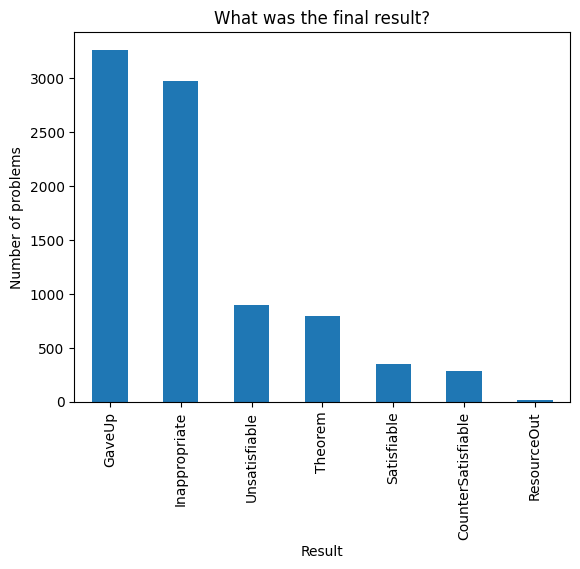

In [35]:
(
    df_se_indi
    [df_se_indi["szs_status"].notnull()]
    ["szs_status"]
    .apply(lambda text: text.replace("SZS status ", ""))
    .value_counts()
    .sort_values(ascending=False)
    .plot(
        title="What was the final result?",
        xlabel="Result",
        ylabel="Number of problems",
        kind="bar",
    )
)
plt.show()

In [22]:
df_tptp

,Problem,spc,n_formulae,n_atoms,n_clauses,n_literals,n_variables,full_file_name
0,TOP036+4.p,FOF_THM_RFO_SEQ,34431.0,241872.0,NaN,NaN,94759.0,TPTP-v9.0.0/Problems/TOP/TOP036+4.p
1,TOP029+1.p,FOF_THM_RFO_SEQ,109.0,569.0,NaN,NaN,184.0,TPTP-v9.0.0/Problems/TOP/TOP029+1.p
2,TOP042+3.p,FOF_THM_RFO_SEQ,13534.0,83921.0,NaN,NaN,33628.0,TPTP-v9.0.0/Problems/TOP/TOP042+3.p
3,TOP008-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP008-1.p
4,TOP009-1.p,CNF_SAT_RFO_NEQ,NaN,NaN,112.0,339.0,357.0,TPTP-v9.0.0/Problems/TOP/TOP009-1.p
...,...,...,...,...,...,...,...,...
26272,MED007+1.p,FOF_THM_RFO_NEQ,41.0,201.0,NaN,NaN,96.0,TPTP-v9.0.0/Problems/MED/MED007+1.p
26273,MED006+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED006+1.p
26274,MED012+1.p,FOF_SAT_RFO_NEQ,40.0,190.0,NaN,NaN,93.0,TPTP-v9.0.0/Problems/MED/MED012+1.p
26275,MED008+1.p,FOF_THM_RFO_NEQ,41.0,197.0,NaN,NaN,95.0,TPTP-v9.0.0/Problems/MED/MED008+1.p


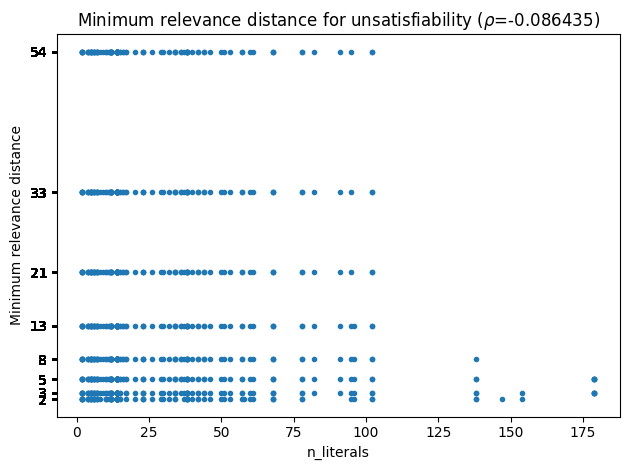

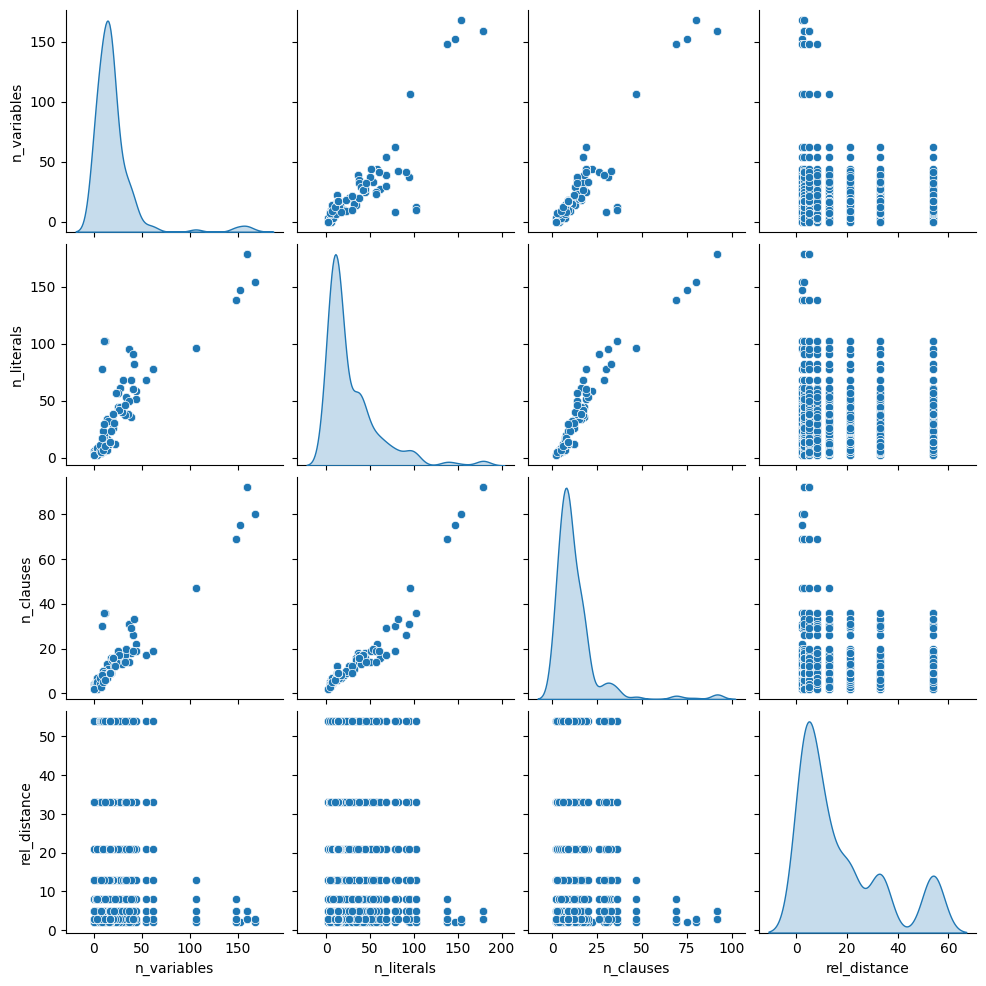

In [ ]:
import seaborn as sns
problem_parameters = ["n_formulae", "n_atoms", "n_variables", "n_literals", "n_clauses"]

df_tptp["problem"] =\
    df_tptp["Problem"].apply(lambda x: x[:x.rindex(".")])

df_merged = (
    df_se_indi
    [
        df_se_indi["szs_status"].notnull()
        & df_se_indi["szs_status"].str.contains("Unsatisfiable")
    ]
    [["problem", "rel_distance"]]
    .merge(
        df_tptp
        [problem_parameters+["problem"]],
        on="problem",
        how="inner"
    )
    [problem_parameters + ["rel_distance"]]
    .apply(lambda x: x[x.notnull() & x.notna()])
    .astype(float)
    .sort_values(by="rel_distance", ascending=True)
    .reset_index(drop=True)
)

parameter = "n_literals"
second_parameter = "rel_distance"
df_merged.plot(
    x=parameter,
    y=[second_parameter],
    style=".",
    ylabel="Minimum relevance distance",
    yticks=df_merged[second_parameter].to_list(),
    title="Minimum relevance distance for unsatisfiability ($\\rho$={:f})"\
        .format(df_merged[parameter].corr(df_merged[second_parameter])),
    legend=False,
)

plt.tight_layout()

sns.pairplot(df_merged.drop(labels=["n_formulae", "n_atoms"], axis=1), diag_kind="kde")

## Profiling

In [ ]:
opts = [
    ("-s", ""),
    ("-r", "5"),
]
problem_dir = df_tptp["full_file_name"][1000]
problem_name = problem_dir[problem_dir.rindex("/")+1:]
args = [
    problem_dir
    # "TPTP-v9.0.0/Problems/AGT/AGT042+1.p"
    # pyres_dir + "/EXAMPLES/PUZ001+1.p"
    # "TPTP-v9.0.0/Problems/MED/MED007+1.p"
    # "TPTP-v9.0.0/Problems/CSR/CSR038+3.p"

]

with cProfile.Profile() as pr:
    pyres_fof.main(from_notebook=True, notebook_opts=opts, notebook_args=args)
    df_function_stats = pd.DataFrame(
        pr.getstats(),
        columns=["func", "ncalls", "ccalls",
                 "tottime", "cumtime", "callers"]
    )
df_function_stats["func"] = df_function_stats["func"].astype(str)
df_function_stats = \
    df_function_stats[ \
        df_function_stats["func"].str.contains(r"PyRes/(\w+)\.py") ]

func_names = []
lines = []
for value in df_function_stats["func"]:
    func_name = re.search(r'(?<=code object )(\w+)', value)
    line = re.search(r'(?<=line )(\d+)', value)
    func_names.append(func_name.group() if func_name is not None else None)
    lines.append(int(line.group()) if line is not None else None)
df_function_stats["func_name"] = func_names
df_function_stats["line"] = lines

df_function_stats = (
        df_function_stats[["func_name", "line", "ncalls", "ccalls",
                  "tottime", "cumtime", "func", "callers"]]
        .sort_values("ncalls", ascending=False)
)


datestring = (
    datetime.now().isoformat()
    .replace("2025-", "")
)
datestring = datestring[:datestring.rindex(".")]

df_function_stats.to_csv(
    str(notebook_dir)
    + f"/profiling/{datestring}_{problem_name}.csv"
    .replace(".p", "")
)
df_function_stats

TPTP-v9.0.0/Problems/SYN/SYN063+1.p
SYN063+1.p
% SZS status Theorem

% Initial clauses    : 31
% Processed clauses  : 42
% Factors computed   : 35
% Resolvents computed: 891
% Tautologies deleted: 0
% Forward subsumed   : 0
% Backward subsumed  : 0
% -------- CPU Time ---------
% User time          : 14.561 s
% System time        : 0.810 s
% Total time         : 15.371 s


/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_55361/2534231915.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_stats = df_stats[ df_stats["func"].str.contains(r"PyRes/(\w+)\.py") ]


,func_name,line,ncalls,ccalls,tottime,cumtime,func,callers
259,termIsVar,73,355727,0,8.787824e-02,8.776720e-02,"<code object termIsVar at 0x107ac1430, file ""/...",[(<code object _clean_thread_parent_frames at ...
284,termIsCompound,81,240897,0,1.244782e-01,6.480846e-02,"<code object termIsCompound at 0x107ae93e0, fi...","[(<code object __or__ at 0x100a85f10, file ""/o..."
260,termFunc,89,106631,0,8.895831e-02,3.291471e-02,"<code object termFunc at 0x107ac1530, file ""/U...",[(<method '__exit__' of 'sqlite3.Connection' o...
261,termArgs,97,70662,0,6.247266e-02,2.770090e-02,"<code object termArgs at 0x107ac1630, file ""/U...",[(<method 'popleft' of 'collections.deque' obj...
285,isNegative,184,40132,0,4.009462e-03,4.009462e-03,"<code object isNegative at 0x107ae94d0, file ""...",None
...,...,...,...,...,...,...,...,...
195,formulaCNFSplit,640,1,0,6.356660e-04,3.738300e-05,"<code object formulaCNFSplit at 0x107947c10, f...","[(<code object getMatrix at 0x1078d6b80, file ..."
193,tptpLexer,49,1,0,2.320000e-04,5.520900e-05,"<code object tptpLexer at 0x107946870, file ""/...","[(<code object __or__ at 0x100a85f10, file ""/o..."
192,addEqAxioms,160,1,0,1.545420e-04,3.041000e-06,"<code object addEqAxioms at 0x107943850, file ...","[(<code object __init__ at 0x107ae8d50, file ""..."
219,getName,197,1,0,2.500000e-07,2.500000e-07,"<code object getName at 0x107a3e100, file ""/Us...",None


#### Filter for alternating path functions 

In [10]:
df_function_stats = pd.read_csv("profiling/profiling_runs.csv", index_col=0)
df_function_stats[ df_function_stats["func"].str.contains("alternatingpath.py") ]

,func_name,line,ncalls,ccalls,tottime,cumtime,func,callers
235,edge_neighb_of_subset,91,8004594,0,0.729436,0.729436,<code object edge_neighb_of_subset at 0x104c1b...,NaN
280,NaN,98,8004594,0,2.787934,2.058498,"<code object <lambda> at 0x104c79200, file ""/U...",[_lsprof.profiler_subentry(code=<code object e...
279,__init__,19,5006,0,0.000657,0.000657,"<code object __init__ at 0x104c79110, file ""/U...",NaN
278,__init__,9,1702,0,0.000144,0.000144,"<code object __init__ at 0x104c79020, file ""/U...",NaN
272,NaN,87,1702,0,0.000163,0.000163,"<code object <lambda> at 0x104c52b30, file ""/U...",NaN
284,get_neighbours,95,1599,0,4.077462,1.289528,"<code object get_neighbours at 0x104c983b0, fi...",[_lsprof.profiler_subentry(code=<code object <...
270,get_all_nodes,73,1,0,0.000036,0.000036,"<code object get_all_nodes at 0x104c52230, fil...",NaN
163,construct_betweenclause_edges,57,1,0,5.855480,0.215930,<code object construct_betweenclause_edges at ...,[_lsprof.profiler_subentry(code=<code object t...
196,nodes_to_clauses,76,1,0,0.000007,0.000006,"<code object nodes_to_clauses at 0x1043e8030, ...",[_lsprof.profiler_subentry(code=<code object _...
199,get_rel_neighbourhood,109,1,0,4.080163,0.002488,<code object get_rel_neighbourhood at 0x1043f3...,[_lsprof.profiler_subentry(code=<code object c...


In [ ]:
import pandas as pd





ModuleNotFoundError: No module named 'PyRes'